<a href="https://colab.research.google.com/github/ahamadshaik/Optical_Character_Recognition/blob/main/OCR_RCNN_CTC_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Overview of OCR pipeline
Hello! My name is <b>Peer Ahamad Shaik.</b> I am a Data Scientist specialising in Computer Vision. In this notebook, I will be providing the Implementation overview of the <b>Optical Character Recognition Pipeline.</b> <br/><br/>
<b>Variation</b> : Dynamic(variational) Image Size<br/>
<b>TAGS</b> : Keras, tf.Data, SROIE 2019, ICDAR 2019, OCR, CTC-LOSS, Beam-Search Decoding <br/>


## Table Of Contents
- [1. Raw Data Exploration](#section1)

- [2. Dataset Preparation](#section2)

- [3. Post-Processed Data Exploration](#section3)

- [4. Data Pipelines](#section4)

- [5. Model Definition and Training](#section5)

- [6. Model Inference and Testing](#section6)

- [7. Replacing optical information with digital information on Image](section7)

- [8. (Optional) Breakdown of network for deeper understanding](section8)

## 1. Data Exploration
<a id="section1"></a>

- <a href = "https://rrc.cvc.uab.es/?ch=13">SROIE</a> stands for Scanned Receipts OCR and Information Extraction.
- <a href = "https://drive.google.com/open?id=1ShItNWXyiY1tFDM5W02bceHuJjyeeJl2">Download</a> the dataset from this link(google drive).
- For this task I am using <u>0325updated.task1train(626p)</u> dataset

In [1]:
# importing libraries
import pathlib

In [2]:
# This directory has .jpg files as images and .txt files for bounding box coordinates and labels.
data_dir = pathlib.Path("/content/drive/MyDrive/SROIE2019/0325updated.task1train(626p)")
img_paths = sorted(list(map(str, data_dir.glob('*.jpg')))) # reading image file paths from directory.
ground_truth_paths = sorted(list(map(str, data_dir.glob('*.txt'))))# reading ground truth file paths from directory.

print('Number of Images found : {}'.format(len(img_paths)))
print('Number of ground truth docs found : {}'. format(len(ground_truth_paths)))

Number of Images found : 712
Number of ground truth docs found : 835


There are some redundancies in dataset. lets see few exmaples.

In [3]:
redundant_images = {}
i, j = 0, 0
for i_p in img_paths:
    if i_p.replace('.jpg', ' (1).jpg') in img_paths:
        redundant_images[i] = [i_p, i_p.replace('.jpg', ' (1).jpg')]
        i+=1

redundant_ground_truths = {}
for g_p in ground_truth_paths:
    if g_p.replace('.txt', ' (1).txt') in ground_truth_paths:
        redundant_ground_truths[j] = [g_p, g_p.replace('.txt', ' (1).txt')]
        j+=1

print('Number of redundant images found : {}'.format(len(redundant_images)))
print('Number of redundant ground truths found : {}'.format(len(redundant_ground_truths)))

Number of redundant images found : 61
Number of redundant ground truths found : 140


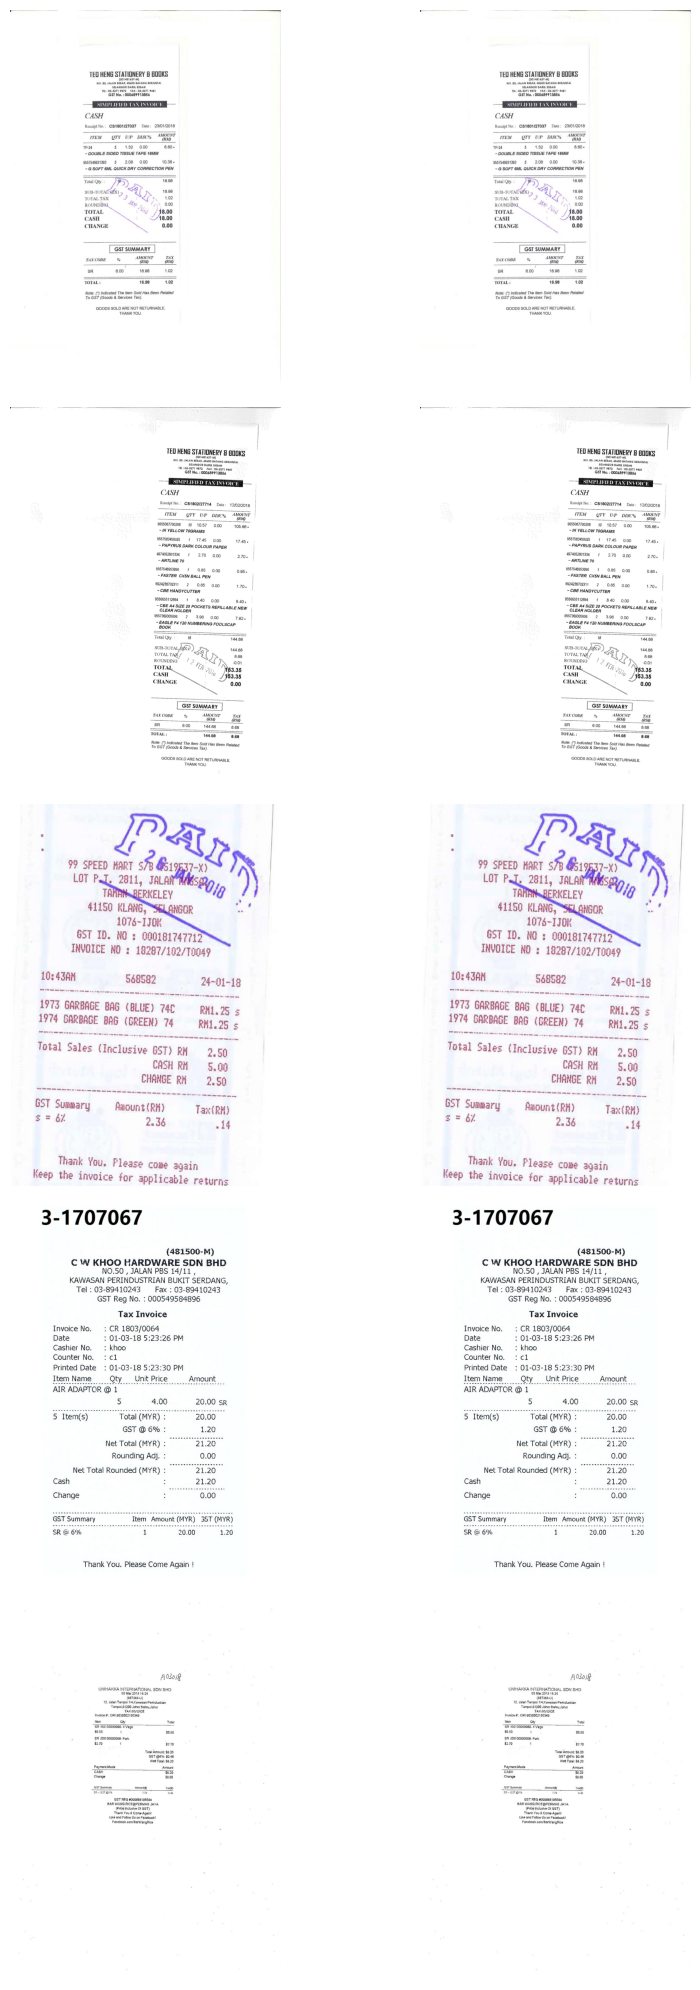

In [4]:
import matplotlib.pyplot as plt
import cv2

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
for row, im_paths in zip(axes, redundant_images):
  img1 = cv2.imread(redundant_images[im_paths][0], cv2.IMREAD_COLOR)
  img2 = cv2.imread(redundant_images[im_paths][1], cv2.IMREAD_COLOR)
  row[0].imshow(img1, cmap='gray')  # Display the first image in the pair
  row[1].imshow(img2, cmap='gray')  # Display the second image in the pair
  row[0].axis('off')  # Hide the axes for the first image
  row[1].axis('off')  # Hide the axes for the second image

plt.tight_layout()
plt.show()
plt.close('all')


## 2. Dataset Preparation
<a id="section2"></a>

Removing redundant images.

In [5]:
## Retrieve Images
images_list = sorted(list(map(str, data_dir.glob('*.jpg'))))
images_list = [im for im in images_list if ' (' not in im]

## Retrieve Ground Truth
label_list = sorted(list(map(str, data_dir.glob('*.txt'))))
label_list = [tr for tr in label_list if ' (' not in tr]

print('Number of reciept images:', len(images_list))
assert len(images_list) == len(label_list)

Number of reciept images: 626


In [6]:
# sample content of ground truth file.
with open(label_list[0], 'rb') as txt_file:
  content = txt_file.readlines()
for i, line in enumerate(content):
  print(line.decode('UTF-8'))
  if i == 5:
    break

72,25,326,25,326,64,72,64,TAN WOON YANN

50,82,440,82,440,121,50,121,BOOK TA .K(TAMAN DAYA) SDN BND

205,121,285,121,285,139,205,139,789417-W

110,144,383,144,383,163,110,163,NO.53 55,57 & 59, JALAN SAGU 18,

192,169,299,169,299,187,192,187,TAMAN DAYA,

162,193,334,193,334,211,162,211,81100 JOHOR BAHRU,



- As we can see there are multiple boundin box coordinates and their associated labels are presented in each ground truth file.
- Usually this operation will be performed by a text detection algorithm.
- However, we are only focusing on only text recognition part for this notebook. We will focus on the text detection pipeline in next notebook.
- **Extracting bounding boxes from each image and storing them in a folder.**
- Each bounding box naming convention follows their original reciept file name follwed by underscore and linenumber in ground truth file. For example: <u>X00016469612_1.jpg</u>
- Further we are also creating a mapper object, which stores the bounding box image name as key and its label as value.

In [7]:
import os
import pickle

In [8]:
bbox_dir = '/content/drive/MyDrive/OCR/SROIE_bboxes/'

In [9]:
# Each receipt contains multiple text fields. Extracting those text fields using label_list.
# This task may take sometime.
mapper = {}
if not os.path.exists(bbox_dir):
    print('Creating SROIE_bboxes directory.')
    os.makedirs(bbox_dir)
for i_c, (image_path, label_path) in enumerate(zip(sorted(images_list), sorted(label_list))):
    image_name = image_path.split('/')[-1].split('.')[0]
    label_filename = label_path.split('/')[-1].split('.')[0]
    assert image_name == label_filename
    image = cv2.imread(image_path)
    with open(label_path, 'r', encoding='utf-8') as f:
        for l_c, line in enumerate(f):
            coordinates = line.split(',')[0:8]
            coordinates = [int(j) for j in coordinates]
            x1, y1, x2, y2, x3, y3, x4, y4 = coordinates
            transcript = ''.join(line.split(',')[8:])
            bbox = image[y1:y3, x1:x3]
            mapper[image_name + '_'+ str(l_c)] = [transcript, bbox.shape[0], bbox.shape[1]]
            #cv2.imwrite(bbox_dir+ image_name +'_'+ str(l_c)+'.jpg', bbox)
    f.close()
    if i_c%50 == 0:
      print(" {} lines have been processed in image {}({}) out of 626 images.".format(l_c, i_c, image_name))

with open('/content/drive/MyDrive/OCR/SROIE_mapper.pkl', 'wb') as f:
    pickle.dump(mapper, f)

 43 lines have been processed in image 0(X00016469612) out of 626 images.
 65 lines have been processed in image 50(X51005442361) out of 626 images.
 57 lines have been processed in image 100(X51005663276) out of 626 images.
 58 lines have been processed in image 150(X51005712038) out of 626 images.
 42 lines have been processed in image 200(X51005757290) out of 626 images.
 43 lines have been processed in image 250(X51006350763) out of 626 images.
 41 lines have been processed in image 300(X51006414680) out of 626 images.
 62 lines have been processed in image 350(X51006556830) out of 626 images.
 52 lines have been processed in image 400(X51006620161) out of 626 images.
 50 lines have been processed in image 450(X51007103692) out of 626 images.
 51 lines have been processed in image 500(X51007339162) out of 626 images.
 34 lines have been processed in image 550(X51008042783) out of 626 images.
 48 lines have been processed in image 600(X51008142034) out of 626 images.


## 3. Post-Processed Data Exploration
<a id = 'section3'></a>

In [10]:
with open('/content/drive/MyDrive/OCR/SROIE_mapper.pkl', 'rb') as f:
    mapper = pickle.load(f)